In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Chicago data

Now with no Gaussian decay, and a histogram in time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels
import opencrimedata.chicago

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

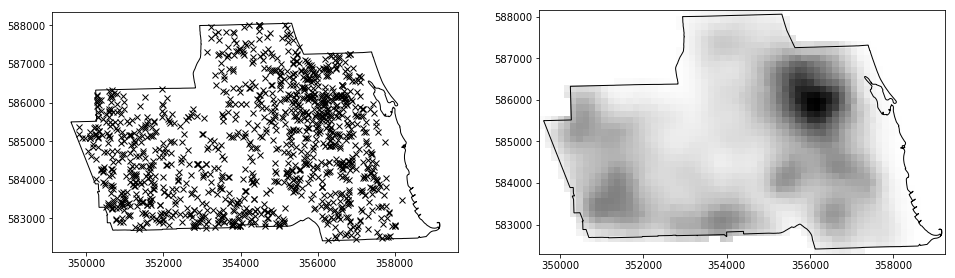

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Train

In [8]:
def plot(model, histlen):
    fig, axes = plt.subplots(ncols=2, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    ax = axes[1]
    x = np.arange(histlen) * model.bandwidth
    ax.bar(x + model.bandwidth/2, model.alpha_array[:len(x)] * model.theta / model.bandwidth,
           model.bandwidth, color="none", edgecolor="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    None

In [9]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=1, use_fast=True)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.020979751046623054, bandwidth=1, r0=20

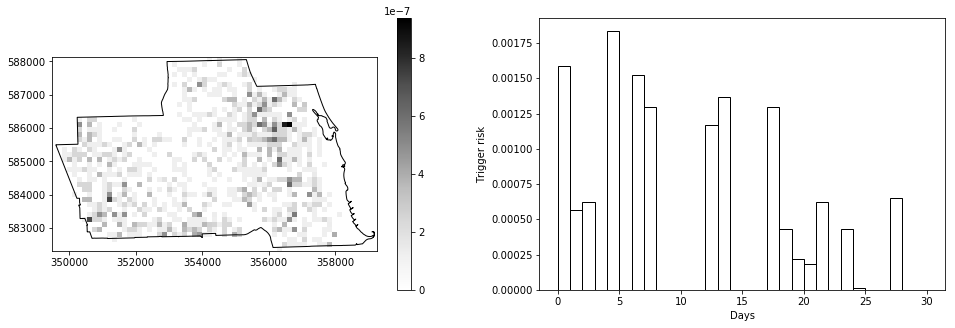

In [10]:
plot(model, 30)

With this new data, we find that often the "edge corrected" algorithm is numerically unstable....

In [11]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=0.5, use_fast=True)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.020075958229778725, bandwidth=0.5, r0=20

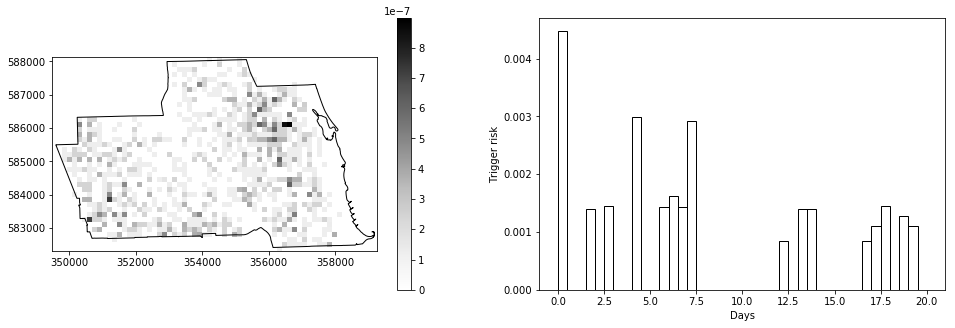

In [12]:
plot(model, 40)

In [13]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=0.1, use_fast=True)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.009380724669024763, bandwidth=0.1, r0=20

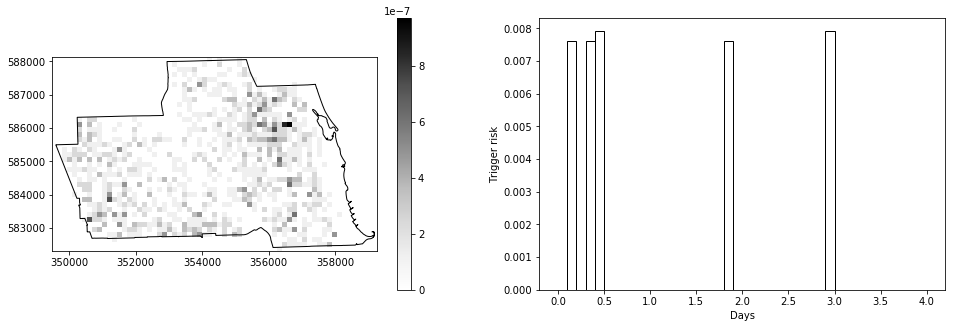

In [14]:
plot(model, 40)

In [15]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=0.8, use_fast=True)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.020931622769010363, bandwidth=0.8, r0=20

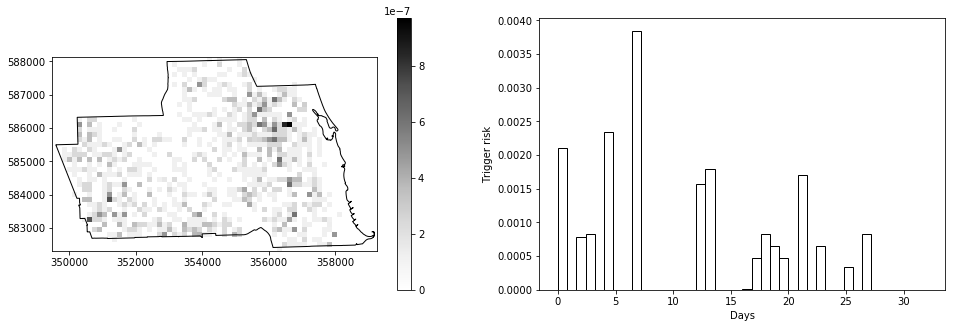

In [16]:
plot(model, 40)

In [17]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=1.2, use_fast=True)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.019189439828489023, bandwidth=1.2, r0=20

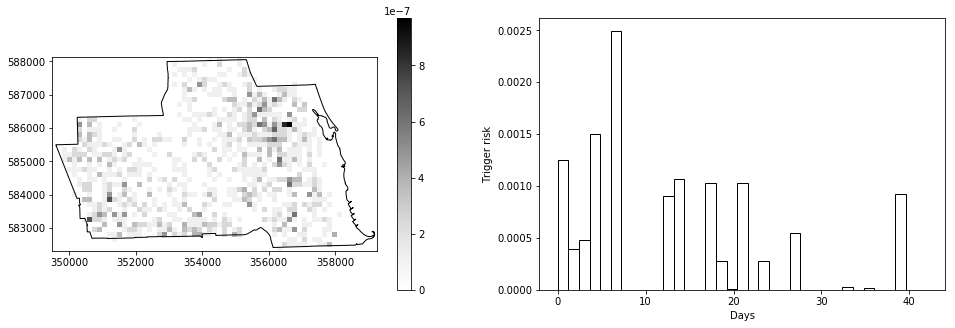

In [18]:
plot(model, 35)

In [19]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=1.3, use_fast=True)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.019105704971655493, bandwidth=1.3, r0=20

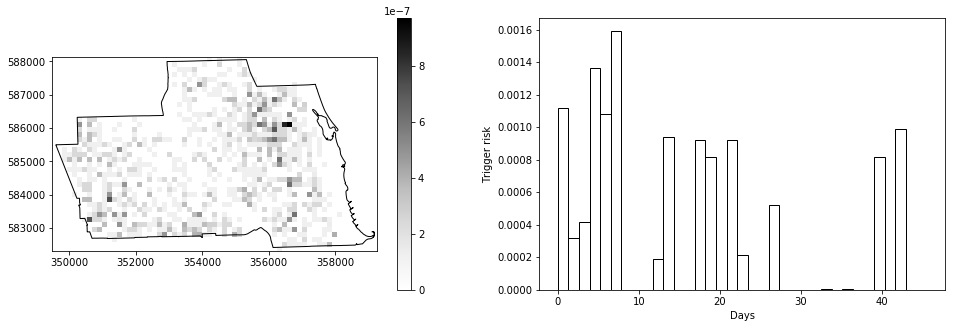

In [20]:
plot(model, 35)

## Different $r_0$ value

This becomes computationally expensive...

In [21]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=100, bandwidth=1)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.02393091896303501, bandwidth=1, r0=100

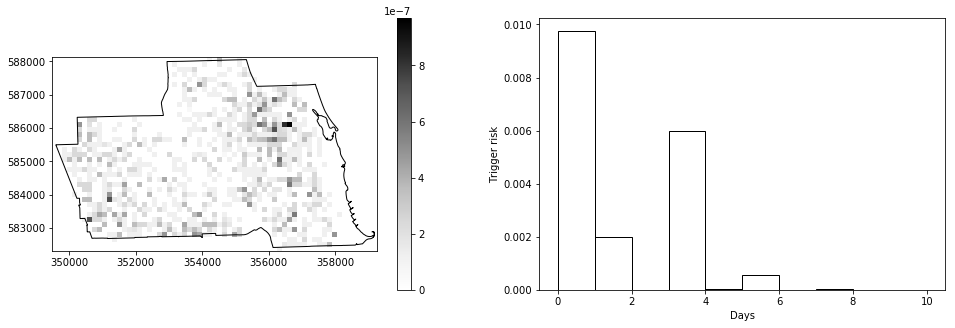

In [22]:
plot(model, 10)

In [23]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=100, bandwidth=0.1)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.015981732095387273, bandwidth=0.1, r0=100

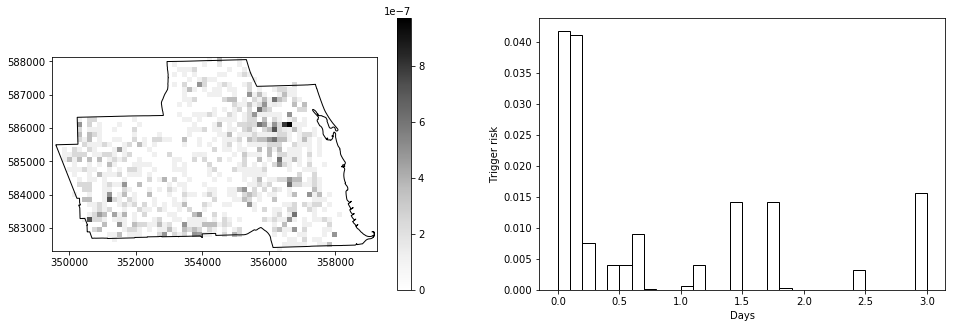

In [24]:
plot(model, 30)

In [25]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=250, bandwidth=1)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.026076837918401576, bandwidth=1, r0=250

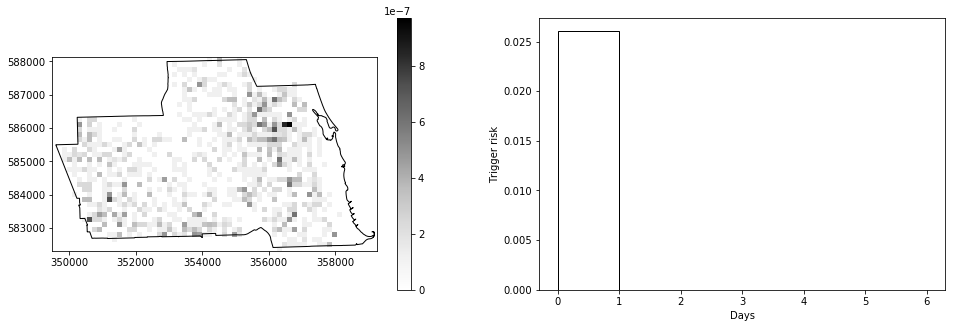

In [26]:
plot(model, 6)

In [27]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=250, bandwidth=0.1)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.03462095673770724, bandwidth=0.1, r0=250

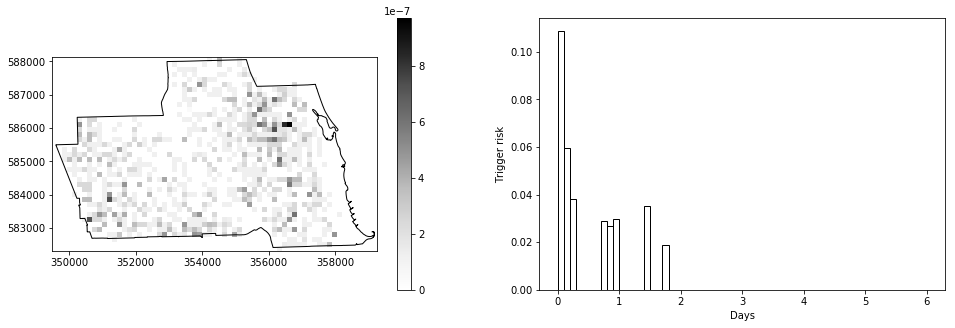

In [28]:
plot(model, 60)